In [6]:
import sys; sys.path.insert(0, '../')

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
from models.snn.factory import build_snn
from models.snn.train import train_model, evaluate_model
from models.snn.tuning import tune_hyperparameters
from models.preprocessing import load_preprocessed

In [8]:
splits, class_names = load_preprocessed('../data/processed/')
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

Loaded train: X=(818, 614400), y=(818, 3)
Loaded val: X=(235, 614400), y=(235, 3)
Loaded test: X=(118, 614400), y=(118, 3)
Loaded class names: ['mark', 'marvin', 'yannes']


X_train: (818, 614400) float32
y_train: (818, 3) float32
class_names: ['mark', 'marvin', 'yannes']


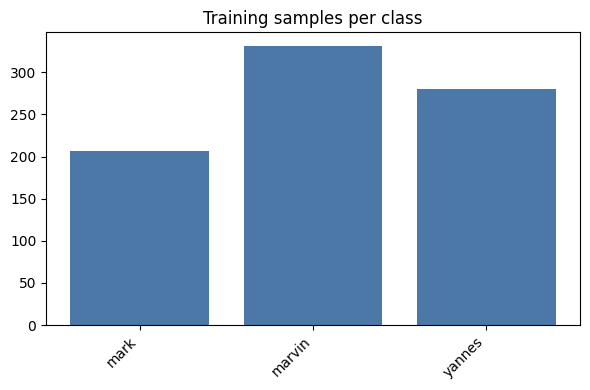

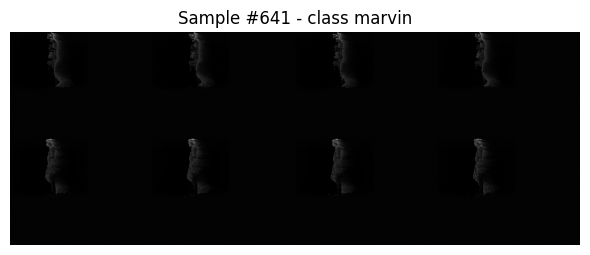

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Basic dataset info
try:
    print("X_train:", getattr(X_train, 'shape', None), getattr(X_train, 'dtype', ''))
    print("y_train:", getattr(y_train, 'shape', None), getattr(y_train, 'dtype', ''))
    print("class_names:", class_names)
except NameError as e:
    print("Dataset variables not found:", e)

# Prepare labels (support one-hot or integer)
labels_1d = None
try:
    y_arr = np.asarray(y_train)
    if y_arr.ndim == 2:
        labels_1d = y_arr.argmax(axis=1)
    else:
        labels_1d = y_arr.astype(int)
except Exception as e:
    print("Could not prepare labels:", e)

# Class distribution
try:
    if labels_1d is not None:
        num_classes = len(class_names) if 'class_names' in globals() else int(labels_1d.max()) + 1
        counts = np.bincount(labels_1d, minlength=num_classes)

        plt.figure(figsize=(6, 4))
        plt.bar(range(num_classes), counts, color="#4C78A8")
        if 'class_names' in globals():
            plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
        else:
            plt.xticks(range(num_classes))
        plt.title('Training samples per class')
        plt.tight_layout()
        plt.show()
    else:
        print("Labels unavailable; skipping class distribution plot.")
except Exception as e:
    print("Could not plot class distribution:", e)

# Show a random sample (reshape flattened vectors to image)
try:
    idx = np.random.randint(0, len(X_train))
    sample = np.asarray(X_train[idx])
    label_name = None
    if labels_1d is not None and 'class_names' in globals():
        if labels_1d[idx] < len(class_names):
            label_name = class_names[labels_1d[idx]]

    title = f"Sample #{idx}" + (f" - class {label_name}" if label_name else "")

    def guess_image_from_flat(vec: np.ndarray) -> np.ndarray:
        vec = np.asarray(vec)
        if vec.ndim == 1:
            # Try common event camera resolutions
            candidates = [(480, 640), (48, 64), (240, 180), (260, 346), (240, 304)]
            for h, w in candidates:
                hw = h * w
                if vec.size % hw == 0:
                    c = vec.size // hw
                    if c in (1, 2, 3, 4, 10):
                        arr = vec.reshape(h, w, c)
                        # If single channel, return 2D
                        if c == 1:
                            return arr[..., 0]
                        # If 2 channels, show side-by-side
                        if c == 2:
                            # Normalize for display
                            left = arr[..., 0]
                            right = arr[..., 1]
                            # Stack with small gap
                            gap = np.zeros((h, 5))
                            return np.concatenate([left, gap, right], axis=1)
                        # If 3/4 channels, assume RGB/RGBA
                        if c in (3, 4):
                            return arr[..., :3]
                        # If 10 bins or other, average across channels
                        return arr.mean(axis=-1)
            # Fallback: try square image
            s = int(np.sqrt(vec.size))
            if s * s == vec.size:
                return vec.reshape(s, s)
            # As last resort, return the vector (cannot image)
            return vec
        elif vec.ndim == 2:
            return vec
        elif vec.ndim == 3:
            # Try channels-last
            if vec.shape[-1] in (1, 3, 4):
                return vec[..., 0] if vec.shape[-1] == 1 else vec[..., :3]
            # Try channels-first
            if vec.shape[0] in (1, 3, 4):
                return vec[0] if vec.shape[0] == 1 else np.moveaxis(vec[:3], 0, -1)
            # Otherwise mean across smallest axis
            axis = int(np.argmin(vec.shape))
            return vec.mean(axis=axis)
        else:
            return np.squeeze(vec)

    img = guess_image_from_flat(sample)
    plt.figure(figsize=(6, 5))
    if isinstance(img, np.ndarray) and img.ndim == 2:
        plt.imshow(img, cmap='gray')
    elif isinstance(img, np.ndarray) and img.ndim == 3:
        plt.imshow(np.clip(img, a_min=None, a_max=None))
    else:
        # If we couldn't make an image, plot the vector
        plt.plot(sample)
        plt.title(title + " (vector plot)")
        plt.tight_layout()
        plt.show()
        raise SystemExit  # Skip the image title/axis handling below

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot sample image:", e)


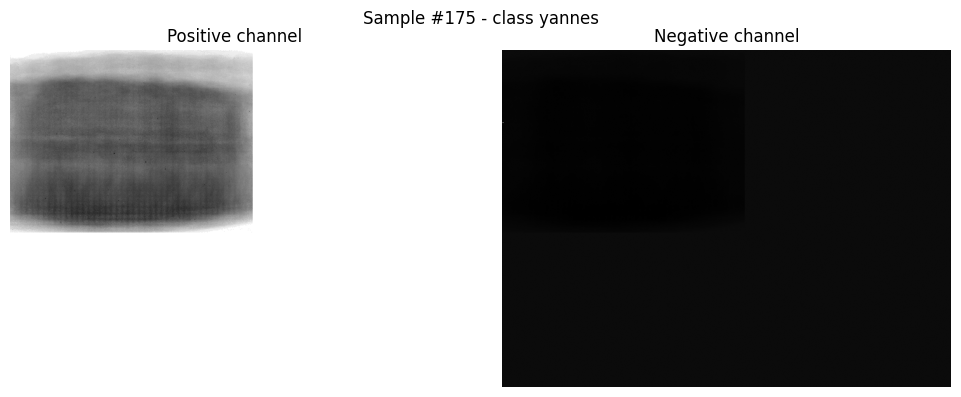

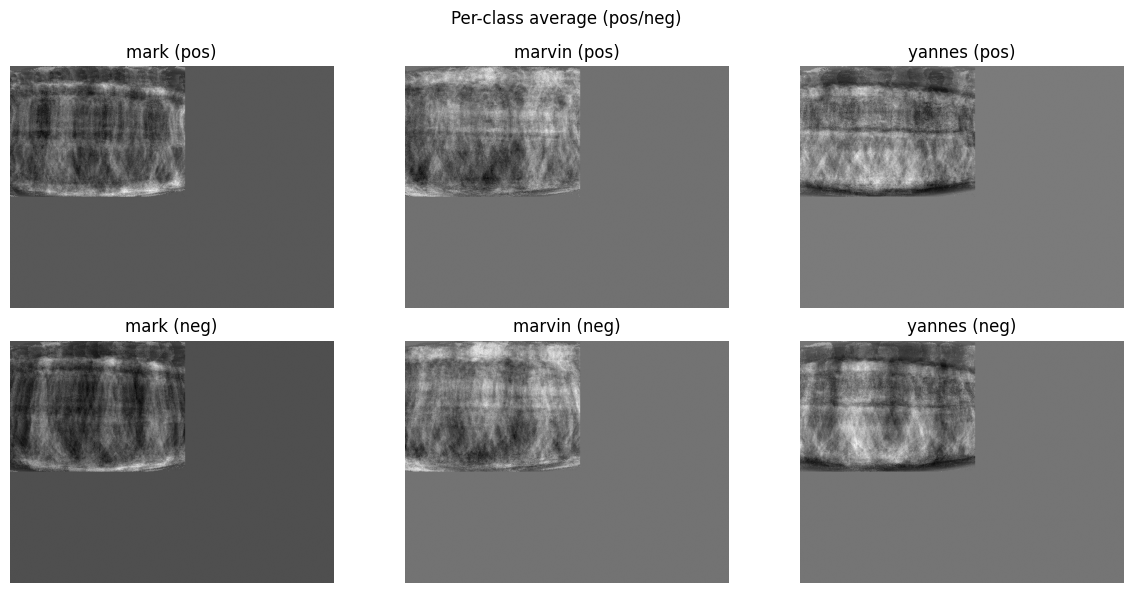

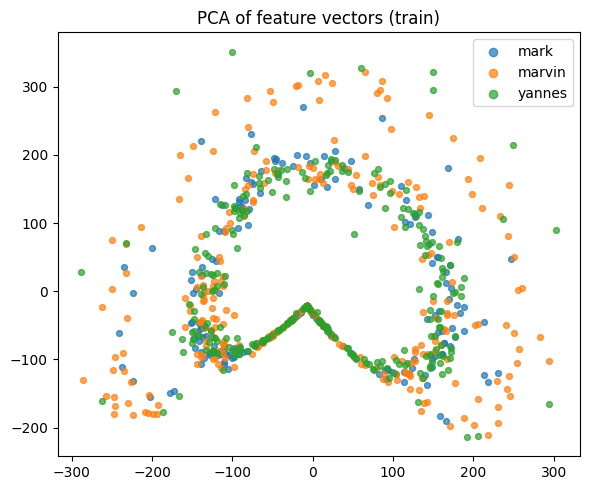

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare labels
labels_1d = None
try:
    y_arr = np.asarray(y_train)
    labels_1d = y_arr.argmax(axis=1) if y_arr.ndim == 2 else y_arr.astype(int)
except Exception as e:
    print("Could not prepare labels:", e)

# Helpers to interpret feature vectors (pos/neg channels)

def infer_hw(half_size: int):
    candidates = [(480, 640), (48, 64), (240, 180), (260, 346), (240, 304)]
    for h, w in candidates:
        if h * w == half_size:
            return h, w
    # fallback: try to factor near sqrt
    s = int(np.sqrt(half_size))
    for h in range(max(1, s - 50), s + 51):
        if half_size % h == 0:
            w = half_size // h
            return h, w
    return None, None


def split_pos_neg(vec: np.ndarray):
    vec = np.asarray(vec)
    if vec.ndim != 1 or vec.size % 2 != 0:
        return None, None, None, None
    half = vec.size // 2
    h, w = infer_hw(half)
    if h is None:
        return None, None, None, None
    pos = vec[:half].reshape(h, w)
    neg = vec[half:].reshape(h, w)
    return pos, neg, h, w


def normalize(arr: np.ndarray):
    arr = np.asarray(arr, dtype=np.float32)
    mn, mx = float(arr.min()), float(arr.max())
    if mx - mn > 1e-8:
        return (arr - mn) / (mx - mn)
    return arr

# 1) Show pos/neg channels for a random training sample
try:
    idx = np.random.randint(0, len(X_train))
    pos, neg, h, w = split_pos_neg(X_train[idx])
    if pos is None:
        raise ValueError("Could not infer (H,W) from feature length")
    cname = class_names[labels_1d[idx]] if labels_1d is not None and 'class_names' in globals() else None

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(normalize(pos), cmap='gray')
    axes[0].set_title('Positive channel')
    axes[0].axis('off')
    axes[1].imshow(normalize(neg), cmap='gray')
    axes[1].set_title('Negative channel')
    axes[1].axis('off')
    suptitle = f"Sample #{idx}" + (f" - class {cname}" if cname else "")
    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot pos/neg sample:", e)

# 2) Per-class average images (pos/neg)
try:
    if labels_1d is not None and 'class_names' in globals():
        n_classes = len(class_names)
        fig, axes = plt.subplots(2, n_classes, figsize=(4*n_classes, 6))
        for c in range(n_classes):
            mask = labels_1d == c
            if not np.any(mask):
                axes[0, c].text(0.5, 0.5, 'No samples', ha='center')
                axes[1, c].text(0.5, 0.5, 'No samples', ha='center')
                axes[0, c].axis('off')
                axes[1, c].axis('off')
                continue
            # Average vectors then split
            mean_vec = X_train[mask].mean(axis=0)
            pos_m, neg_m, _, _ = split_pos_neg(mean_vec)
            axes[0, c].imshow(normalize(pos_m), cmap='gray')
            axes[0, c].set_title(f"{class_names[c]} (pos)")
            axes[0, c].axis('off')
            axes[1, c].imshow(normalize(neg_m), cmap='gray')
            axes[1, c].set_title(f"{class_names[c]} (neg)")
            axes[1, c].axis('off')
        plt.suptitle('Per-class average (pos/neg)')
        plt.tight_layout()
        plt.show()
    else:
        print("Labels or class_names unavailable; skipping per-class averages.")
except Exception as e:
    print("Could not plot per-class averages:", e)

# 3) PCA 2D scatter of samples colored by class
try:
    if labels_1d is not None:
        pca = PCA(n_components=2, svd_solver='randomized', iterated_power=3, random_state=42)
        Z = pca.fit_transform(X_train)
        plt.figure(figsize=(6, 5))
        for c in np.unique(labels_1d):
            mask = labels_1d == c
            lbl = class_names[c] if 'class_names' in globals() and c < len(class_names) else str(c)
            plt.scatter(Z[mask, 0], Z[mask, 1], s=18, alpha=0.7, label=lbl)
        plt.title('PCA of feature vectors (train)')
        plt.legend(markerscale=1.4)
        plt.tight_layout()
        plt.show()
    else:
        print("Labels unavailable; skipping PCA scatter.")
except Exception as e:
    print("Could not plot PCA scatter:", e)


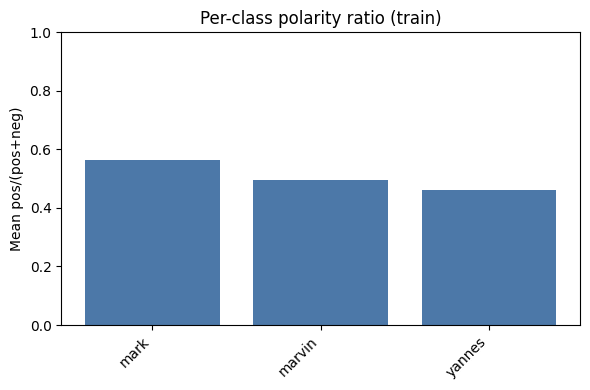

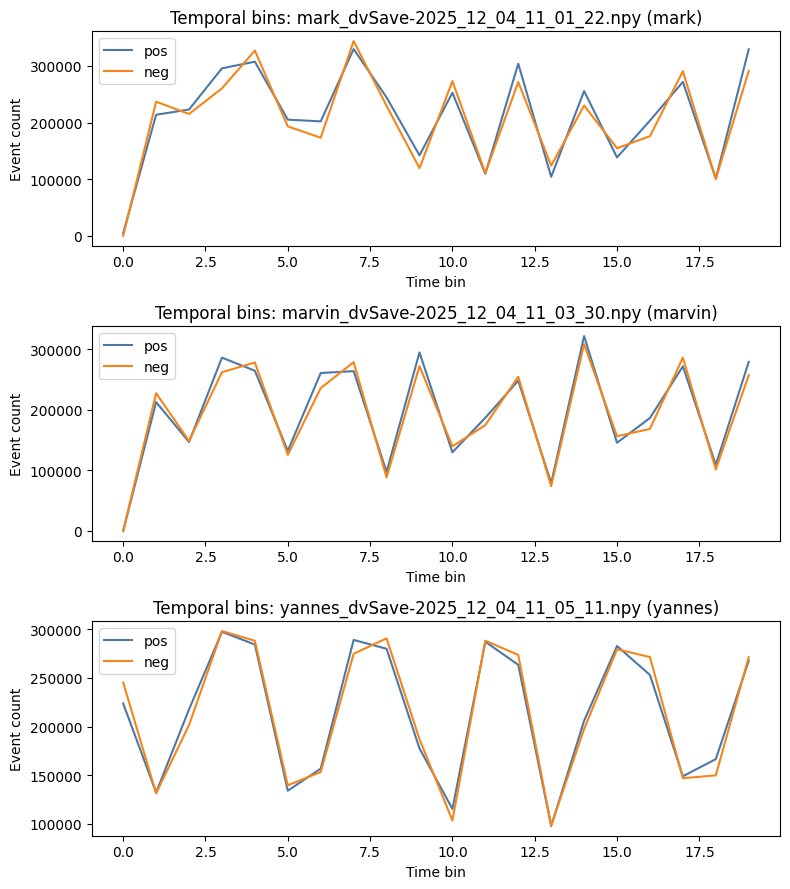

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Pos/Neg ratios per class from preprocessed features ---
try:
    # Prepare labels (support one-hot or integer)
    y_arr = np.asarray(y_train)
    labels_1d = y_arr.argmax(axis=1) if y_arr.ndim == 2 else y_arr.astype(int)
    n_classes = len(class_names) if 'class_names' in globals() else int(labels_1d.max()) + 1

    half = X_train.shape[1] // 2
    pos_sums = X_train[:, :half].sum(axis=1)
    neg_sums = X_train[:, half:].sum(axis=1)

    ratios = []
    for c in range(n_classes):
        mask = labels_1d == c
        if not np.any(mask):
            ratios.append(0.0)
            continue
        # Mean per-sample ratio within the class
        class_pos = pos_sums[mask]
        class_neg = neg_sums[mask]
        per_sample_ratio = class_pos / (class_pos + class_neg + 1e-9)
        ratios.append(float(per_sample_ratio.mean()))

    plt.figure(figsize=(6, 4))
    plt.bar(range(n_classes), ratios, color="#4C78A8")
    if 'class_names' in globals():
        plt.xticks(range(n_classes), class_names, rotation=45, ha='right')
    else:
        plt.xticks(range(n_classes))
    plt.ylim(0, 1)
    plt.ylabel('Mean pos/(pos+neg)')
    plt.title('Per-class polarity ratio (train)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute pos/neg ratios:", e)

# --- Temporal bins from raw events (.npy) ---
# This uses raw event files in ../data/binary and bins time into N bins,
# plotting positive and negative event counts per bin.
try:
    data_dir = Path('../data/binary')
    event_files = sorted([p for p in data_dir.glob('*.npy') if p.is_file()])
    if not event_files:
        raise FileNotFoundError(f"No .npy event files found in {data_dir}")

    # Pick up to 3 files (ideally across classes)
    def label_from_name(name: str) -> str:
        return name.split('_', 1)[0]

    picked = []
    seen_labels = set()
    for f in event_files:
        lbl = label_from_name(f.name)
        if lbl not in seen_labels:
            picked.append(f)
            seen_labels.add(lbl)
        if len(picked) >= 3:
            break
    if not picked:
        picked = event_files[:1]

    n_bins = 20
    fig, axes = plt.subplots(len(picked), 1, figsize=(8, 3 * len(picked)), squeeze=False)
    axes = axes[:, 0]

    for i, f in enumerate(picked):
        events = np.load(f, allow_pickle=True)
        # Expect structured array with fields: t, x, y, p
        if not isinstance(events, np.ndarray):
            raise TypeError("Loaded events are not a numpy array")
        if events.dtype.fields is None or not all(k in events.dtype.fields for k in ('t', 'x', 'y', 'p')):
            raise ValueError(f"File {f.name} does not contain structured events with fields (t,x,y,p)")

        t = events['t']
        pos_mask = events['p'] == 1
        neg_mask = events['p'] == 0

        t_min = t.min()
        t_max = t.max()
        if t_max == t_min:
            bins = np.zeros_like(t, dtype=np.int32)
        else:
            t_norm = (t - t_min) / (t_max - t_min)
            bins = np.clip((t_norm * n_bins).astype(np.int32), 0, n_bins - 1)

        counts_pos = np.bincount(bins[pos_mask], minlength=n_bins)
        counts_neg = np.bincount(bins[neg_mask], minlength=n_bins)

        ax = axes[i]
        ax.plot(counts_pos, label='pos', color='#4C78A8')
        ax.plot(counts_neg, label='neg', color='#F58518')
        ax.set_title(f"Temporal bins: {f.name} ({label_from_name(f.name)})")
        ax.set_xlabel('Time bin')
        ax.set_ylabel('Event count')
        ax.legend()

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot temporal bins:", e)


{
  "cell_type": "markdown",
  "metadata": {"language": "markdown"},
  "source": [
    "## Temporal Dynamics Per Class",
    "We aggregate raw event streams per class, bin time into fixed segments, and plot the mean ± std for positive and negative event counts. This reveals characteristic motion/activity patterns by class."
  ]
}


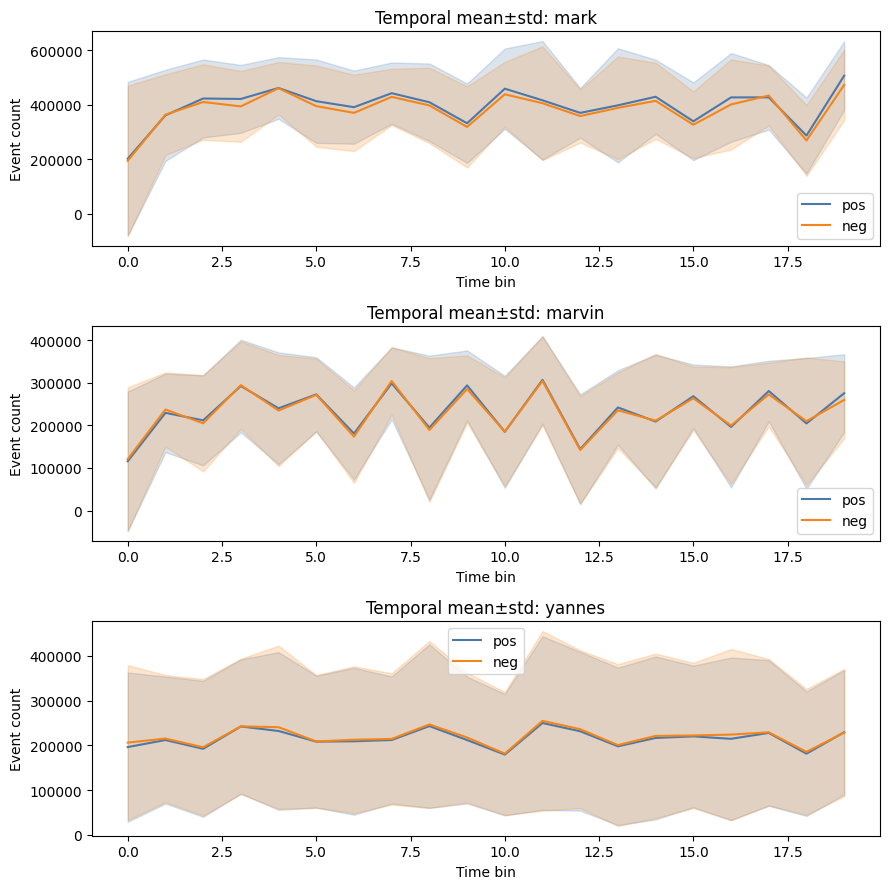

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Aggregate raw event time-bins per class and show mean±std for pos/neg
try:
    data_dir = Path('../data/binary')
    event_files = sorted([p for p in data_dir.glob('*.npy') if p.is_file()])
    if not event_files:
        raise FileNotFoundError(f"No .npy event files found in {data_dir}")

    def label_from_name(name: str) -> str:
        return name.split('_', 1)[0]

    # Group files by label found in file name
    files_by_label = {}
    for f in event_files:
        lbl = label_from_name(f.name)
        files_by_label.setdefault(lbl, []).append(f)

    # Use class_names order when available
    labels_order = class_names if 'class_names' in globals() else sorted(files_by_label.keys())

    n_bins = 20
    max_files_per_class = 10

    fig, axes = plt.subplots(len(labels_order), 1, figsize=(9, 3 * len(labels_order)), squeeze=False)
    axes = axes[:, 0]

    for i, lbl in enumerate(labels_order):
        files = files_by_label.get(lbl, [])[:max_files_per_class]
        if not files:
            axes[i].text(0.5, 0.5, f'No files for class {lbl}', ha='center')
            axes[i].axis('off')
            continue

        pos_mat = []
        neg_mat = []
        for f in files:
            events = np.load(f, allow_pickle=True)
            if events.dtype.fields is None or not all(k in events.dtype.fields for k in ('t', 'x', 'y', 'p')):
                continue
            t = events['t']
            pos_mask = events['p'] == 1
            neg_mask = events['p'] == 0
            t_min, t_max = t.min(), t.max()
            if t_max == t_min:
                bins = np.zeros_like(t, dtype=np.int32)
            else:
                t_norm = (t - t_min) / (t_max - t_min)
                bins = np.clip((t_norm * n_bins).astype(np.int32), 0, n_bins - 1)
            counts_pos = np.bincount(bins[pos_mask], minlength=n_bins)
            counts_neg = np.bincount(bins[neg_mask], minlength=n_bins)
            pos_mat.append(counts_pos)
            neg_mat.append(counts_neg)

        pos_mat = np.stack(pos_mat, axis=0)
        neg_mat = np.stack(neg_mat, axis=0)
        mean_pos, std_pos = pos_mat.mean(axis=0), pos_mat.std(axis=0)
        mean_neg, std_neg = neg_mat.mean(axis=0), neg_mat.std(axis=0)

        ax = axes[i]
        x = np.arange(n_bins)
        ax.plot(x, mean_pos, label='pos', color='#4C78A8')
        ax.fill_between(x, mean_pos - std_pos, mean_pos + std_pos, color='#4C78A8', alpha=0.2)
        ax.plot(x, mean_neg, label='neg', color='#F58518')
        ax.fill_between(x, mean_neg - std_neg, mean_neg + std_neg, color='#F58518', alpha=0.2)
        ax.set_title(f"Temporal mean±std: {lbl}")
        ax.set_xlabel('Time bin')
        ax.set_ylabel('Event count')
        ax.legend()

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute per-class temporal summary:", e)


{
  "cell_type": "markdown",
  "metadata": {"language": "markdown"},
  "source": [
    "## Embedding: UMAP or t-SNE",
    "We reduce high-dimensional features with PCA to 50 components, then embed with UMAP (if available) or t-SNE. Points are colored by class to inspect separability."
  ]
}


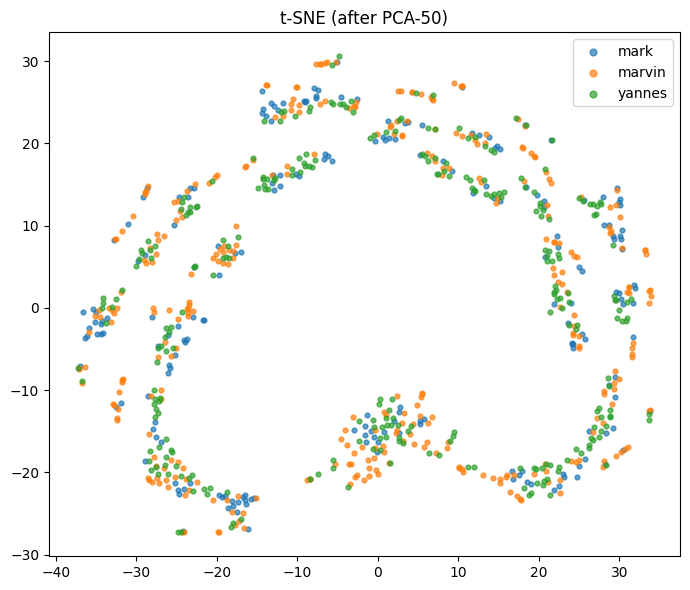

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Try UMAP; fall back to t-SNE if umap-learn is not installed
use_umap = False
try:
    import umap
    use_umap = True
except Exception:
    from sklearn.manifold import TSNE

try:
    # Prepare labels
    y_arr = np.asarray(y_train)
    labels_1d = y_arr.argmax(axis=1) if y_arr.ndim == 2 else y_arr.astype(int)
    n_classes = len(class_names) if 'class_names' in globals() else int(labels_1d.max()) + 1

    # PCA to 50 dims for speed/stability
    pca50 = PCA(n_components=50, svd_solver='randomized', iterated_power=3, random_state=42)
    X_red = pca50.fit_transform(X_train)

    if use_umap:
        embedder = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
        Z = embedder.fit_transform(X_red)
        title = 'UMAP (after PCA-50)'
    else:
        embedder = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
        Z = embedder.fit_transform(X_red)
        title = 't-SNE (after PCA-50)'

    plt.figure(figsize=(7, 6))
    for c in np.unique(labels_1d):
        mask = labels_1d == c
        lbl = class_names[c] if 'class_names' in globals() and c < len(class_names) else str(c)
        plt.scatter(Z[mask, 0], Z[mask, 1], s=12, alpha=0.7, label=lbl)
    plt.title(title)
    plt.legend(markerscale=1.4)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute embedding:", e)


{
  "cell_type": "markdown",
  "metadata": {"language": "markdown"},
  "source": [
    "## Preprocessing Window (time_surface)",
    "This reproduces the preprocessing pipeline windowing: activity filtering and 1000 ms windows, then computes the `time_surface` features to visualize the positive/negative surfaces for a specific window."
  ]
}


interactive(children=(Dropdown(description='File', options=('../data/binary/mark_dvSave-2025_12_04_11_01_22.np…

  Activity filter: Removed 6.4% of events (window=1000ms, min_events=75000)


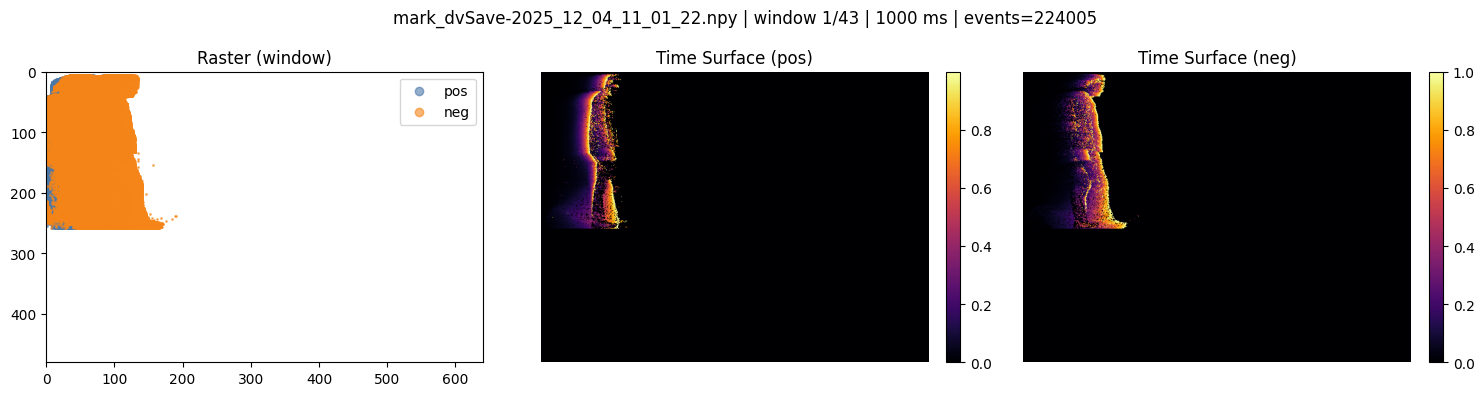

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ipywidgets import interact, Dropdown, IntText
from models.preprocessing import (
    load_event_file,
    filter_events_by_activity,
    split_events_into_windows,
    events_to_features,
)

# Config taken from preprocess_data.py
FEATURE_METHOD = 'time_surface'
SPATIAL_DOWNSAMPLE = False
TARGET_WIDTH = 64
TARGET_HEIGHT = 48
EVENT_WINDOW_MS = 1000
ACTIVITY_WINDOW_MS = 1000
ACTIVITY_MIN_EVENTS = 75000
WIDTH = 640 if not SPATIAL_DOWNSAMPLE else TARGET_WIDTH
HEIGHT = 480 if not SPATIAL_DOWNSAMPLE else TARGET_HEIGHT


def view_preprocessing_window(file_path: str | Path, window_index: int = 0):
    p = Path(file_path)
    events = load_event_file(p)
    if len(events) == 0:
        print(f"No events in {p.name}")
        return

    # Apply activity filter (same as preprocessing)
    events_filt = filter_events_by_activity(
        events,
        window_ms=ACTIVITY_WINDOW_MS,
        min_events_per_window=ACTIVITY_MIN_EVENTS,
    )
    if len(events_filt) == 0:
        print("All events removed by activity filter")
        return

    # Split into 1000 ms windows
    windows = split_events_into_windows(events_filt, EVENT_WINDOW_MS)
    if not windows:
        print("No windows produced")
        return

    widx = int(np.clip(window_index, 0, len(windows)-1))
    win_ev = windows[widx]

    # Compute time_surface features (same method used in preprocess)
    feat = events_to_features(
        win_ev,
        method=FEATURE_METHOD,
        width=WIDTH,
        height=HEIGHT,
        n_bins=10,  # not used by time_surface, kept for signature
    )
    half = WIDTH * HEIGHT
    pos_surf = feat[:half].reshape(HEIGHT, WIDTH)
    neg_surf = feat[half:].reshape(HEIGHT, WIDTH)

    # Raster for the window
    x = np.clip(win_ev['x'], 0, WIDTH - 1)
    y = np.clip(win_ev['y'], 0, HEIGHT - 1)
    ppol = win_ev['p']

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].scatter(x[ppol == 1], y[ppol == 1], s=1, c='#4C78A8', alpha=0.6, label='pos')
    axes[0].scatter(x[ppol == 0], y[ppol == 0], s=1, c='#F58518', alpha=0.6, label='neg')
    axes[0].invert_yaxis()
    axes[0].set_xlim(0, WIDTH)
    axes[0].set_ylim(HEIGHT, 0)
    axes[0].set_title('Raster (window)')
    axes[0].legend(markerscale=6)

    im1 = axes[1].imshow(pos_surf, cmap='inferno', origin='upper')
    axes[1].set_title('Time Surface (pos)')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(neg_surf, cmap='inferno', origin='upper')
    axes[2].set_title('Time Surface (neg)')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    supt = f"{p.name} | window {widx+1}/{len(windows)} | {EVENT_WINDOW_MS} ms | events={len(win_ev)}"
    fig.suptitle(supt)
    plt.tight_layout()
    plt.show()

# Interactive controls
try:
    bin_dir = Path('../data/binary')
    files = sorted([str(p) for p in bin_dir.glob('*.npy')])
    if files:
        interact(view_preprocessing_window,
                 file_path=Dropdown(options=files, description='File'),
                 window_index=IntText(value=0, description='Index'))
    else:
        print(f"No .npy files found in {bin_dir}")
except Exception as e:
    print("Interactive preprocessing viewer setup failed:", e)

# Show a default example immediately
if 'files' in locals() and files:
    view_preprocessing_window(files[0], window_index=0)


{
  "cell_type": "markdown",
  "metadata": {"language": "markdown"},
  "source": [
    "## View Preprocessed Window",
    "Use the already loaded preprocessed splits (train/val/test). Each row in `X_*` corresponds to one 1000 ms window. This viewer reconstructs the positive/negative time surfaces and a pos−neg difference image for a selected sample."
  ]
}


interactive(children=(Dropdown(description='Split', options=('train', 'val', 'test'), value='train'), IntText(…

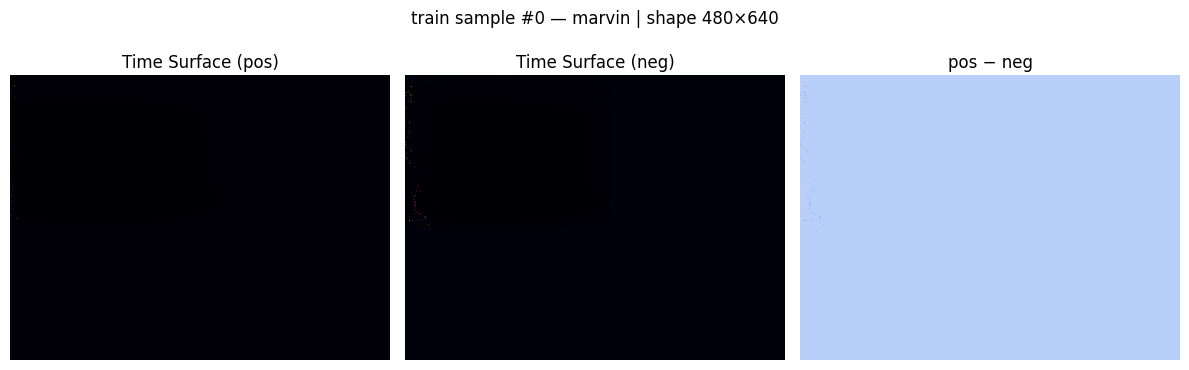

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntText

# Reconstruct pos/neg time surfaces from preprocessed features
CANDIDATE_HW = [(480, 640), (64, 64), (48, 64), (240, 180), (260, 346), (240, 304)]

def infer_hw_from_half(half_size: int):
    for h, w in CANDIDATE_HW:
        if h * w == half_size:
            return h, w
    s = int(np.sqrt(half_size))
    for h in range(max(1, s - 50), s + 51):
        if half_size % h == 0:
            return h, half_size // h
    return None, None


def get_split(name: str):
    if name == 'train':
        return X_train, y_train
    if name == 'val':
        return X_val, y_val
    if name == 'test':
        return X_test, y_test
    raise ValueError('Unknown split')


def view_preprocessed(split: str = 'train', index: int = 0, show_diff: bool = True):
    X, y = get_split(split)
    if not (0 <= index < len(X)):
        print(f'Index out of range for {split}: {index}/{len(X)-1}')
        return

    vec = np.asarray(X[index])
    if vec.ndim != 1 or vec.size % 2 != 0:
        print('Feature vector not in expected [pos, neg] concatenation format')
        return

    half = vec.size // 2
    h, w = infer_hw_from_half(half)
    if h is None:
        print('Could not infer (H,W) from vector length')
        return

    pos = vec[:half].reshape(h, w)
    neg = vec[half:].reshape(h, w)

    # Determine label name if one-hot
    y_arr = np.asarray(y)
    lbl = None
    if y_arr.ndim == 2:
        c = int(y_arr[index].argmax())
        if 'class_names' in globals() and c < len(class_names):
            lbl = class_names[c]
    elif y_arr.ndim == 1:
        c = int(y_arr[index])
        if 'class_names' in globals() and c < len(class_names):
            lbl = class_names[c]

    fig_cols = 3 if show_diff else 2
    fig, axes = plt.subplots(1, fig_cols, figsize=(12, 4))

    axes[0].imshow(pos, cmap='inferno', origin='upper')
    axes[0].set_title('Time Surface (pos)')
    axes[0].axis('off')

    axes[1].imshow(neg, cmap='inferno', origin='upper')
    axes[1].set_title('Time Surface (neg)')
    axes[1].axis('off')

    if show_diff:
        diff = pos - neg
        axes[2].imshow(diff, cmap='coolwarm', origin='upper')
        axes[2].set_title('pos − neg')
        axes[2].axis('off')

    suptitle = f'{split} sample #{index}' + (f' — {lbl}' if lbl else '') + f' | shape {h}×{w}'
    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# Interactive controls
try:
    interact(view_preprocessed,
             split=Dropdown(options=['train', 'val', 'test'], value='train', description='Split'),
             index=IntText(value=0, description='Index'),
             show_diff=Dropdown(options=[True, False], value=True, description='Show diff'))
except Exception as e:
    print('Interactive setup failed:', e)

# Show a default example immediately
view_preprocessed('train', 0, True)
